In [66]:
# CELL 1: Imports
import matplotlib.pyplot as plt
import random
import numpy as np  # We use numpy for easier data handling

# Use a style for the plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [67]:
# CELL 2: The Traffic Model Class

class TrafficModel:
    def __init__(self, length=200, n_cars=50, v_max=5, p=0.25):
        self.L = length          # Road Length
        self.N = n_cars          # Number of Cars
        self.v_max = v_max       # Speed Limit
        self.p = p               # Probability of slowing down
        
        # Initialize the road with -1 (empty)
        # We will use -1 to represent an empty spot.
        # Any >= 0 value represents a car with that velocity.
        self.road = [-1] * self.L
        self.initialize_road()

    def initialize_road(self):
        """Places N cars at random positions with velocity 0."""
        # Create a list of all available positions [0, 1, 2, ... L-1]
        all_positions = list(range(self.L))
        # Randomly choose N unique positions
        occupied_positions = random.sample(all_positions, self.N)
        
        for pos in occupied_positions:
            self.road[pos] = 0  # Start at rest [cite: 27]

    def get_distance(self, current_pos):
        """Calculates distance 'd' to the next car ahead."""
        distance = 1
        # Look ahead one step at a time until we find a car or circle back
        while distance < self.L:
            check_pos = (current_pos + distance) % self.L
            if self.road[check_pos] != -1: # Found a car!
                return distance
            distance += 1
        return distance

    def step(self):
        """Performs one full time step (The 4 Rules)."""
        
        # 1. Identify where all cars are right now
        # We store (position, velocity) pairs to avoid updating the road "in-place"
        # which would mess up the parallel update logic.
        current_cars = [] 
        for i in range(self.L):
            if self.road[i] != -1:
                current_cars.append((i, self.road[i]))

        # We need a NEW blank road for the next time step
        new_road = [-1] * self.L
        
        # Iterate through every car to calculate its move
        for pos, v in current_cars:
            
            # --- RULE 1: Acceleration ---
            # "Everyone tries to accelerate up to the speed limit" [cite: 11]
            if v < self.v_max:
                v += 1
            
            # --- RULE 2: Braking ---
            # "Drivers don't want to hit the car in front" [cite: 12]
            d = self.get_distance(pos)
            if v >= d:
                v = d - 1
            
            # --- RULE 3: Randomization ---
            # "Unexpected events cause slowing down" [cite: 15]
            if v > 0:
                if random.random() < self.p:
                    v -= 1
            
            # --- RULE 4: Movement ---
            # "Each vehicle is moved forward v places" [cite: 18]
            new_pos = (pos + v) % self.L
            new_road[new_pos] = v
            
        # Update the state of the road
        self.road = new_road

    def run(self, steps=100):
        """Runs the simulation and returns the history for plotting."""
        history = []
        for _ in range(steps):
            # Save a copy of the current road (convert -1 to something visible or NaN)
            # For visualization, we turn -1 (empty) into a distinct number, e.g., -2
            # so we can color it white/grey in the plot.
            snapshot = [val if val != -1 else -1 for val in self.road]
            history.append(snapshot)
            self.step()
        return np.array(history)

print("Traffic Model class defined.")

Traffic Model class defined.


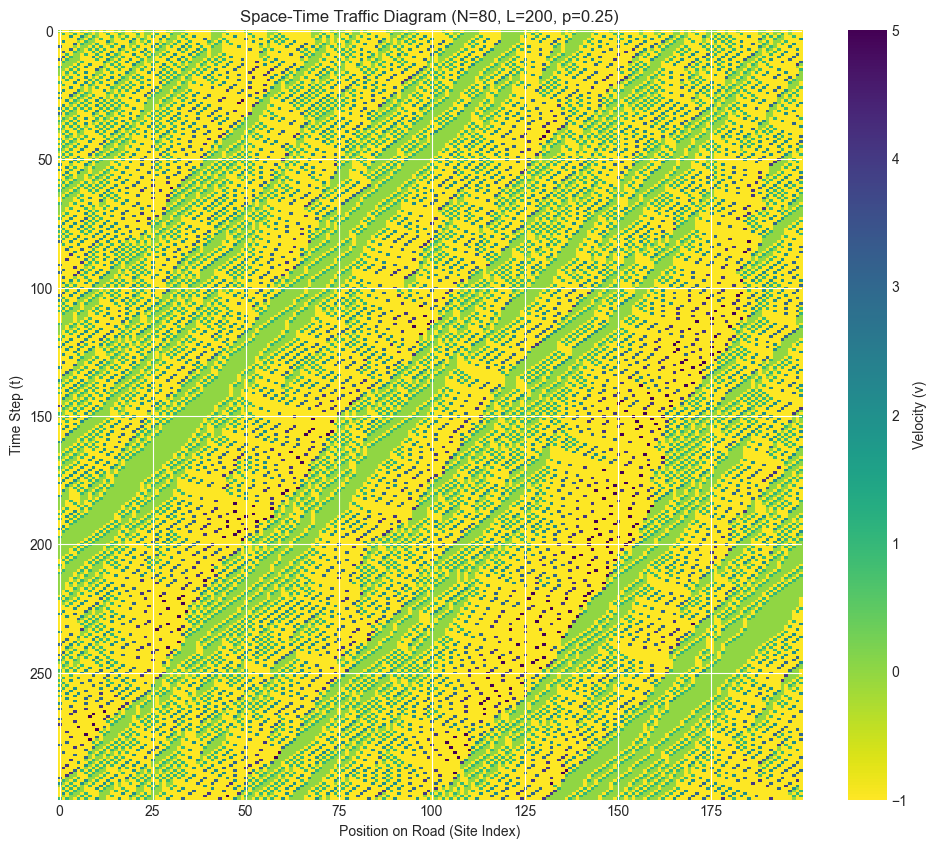

In [68]:
# CELL 3: Run and Visualize

# Parameters
road_length = 200    # [cite: 27]
n_cars = 80          # Try changing this to see different densities!
time_steps = 300     # How long to watch

# Run Simulation
model = TrafficModel(length=road_length, n_cars=n_cars, p=0.25)
data = model.run(steps=time_steps)

# Plotting
plt.figure(figsize=(12, 10))

# We use a custom color map: 
# -1 (Empty) = White
# 0 (Stopped) = Red
# 5 (Fast) = Green
plt.imshow(data, cmap='viridis_r', aspect='auto', interpolation='nearest')

plt.xlabel("Position on Road (Site Index)")
plt.ylabel("Time Step (t)")
plt.title(f"Space-Time Traffic Diagram (N={n_cars}, L={road_length}, p=0.25)")
cbar = plt.colorbar()
cbar.set_label("Velocity (v)")

plt.savefig('images/investigation_1_spacetime_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

Running experiment with CORRECTED flow calculation...


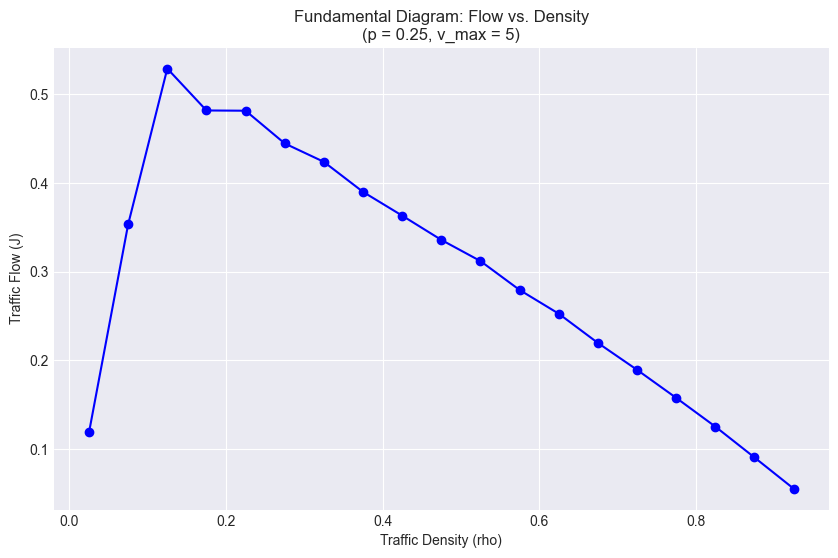

In [69]:
# CELL 4: Corrected Flow vs Density Experiment

densities = []
flows = []

print("Running experiment with CORRECTED flow calculation...")

for n in range(5, 195, 10):
    # 1. Setup
    L = 200
    model = TrafficModel(length=L, n_cars=n, p=0.25)
    
    # 2. Warm-up (Let jams form)
    for _ in range(200):
        model.step()
        
    # 3. Measure Flow (The "Flux" Method)
    # Flow = (Total Distance Moved by ALL cars) / (Road Length * Time)
    total_distance = 0
    measure_steps = 500
    
    for _ in range(measure_steps):
        model.step()
        # Sum the velocities of all cars on the road right now
        # Cars with v=0 (stopped) add nothing to the flow!
        current_velocities = [v for v in model.road if v != -1]
        total_distance += sum(current_velocities)
        
    # Calculate Metrics
    density = n / L
    # Flow J = Total displacement / (L * T)
    flow = total_distance / (L * measure_steps)
    
    densities.append(density)
    flows.append(flow)

# Plotting the Fundamental Diagram
plt.figure(figsize=(10, 6))
plt.plot(densities, flows, '-o', c='blue')
plt.xlabel("Traffic Density (rho)")
plt.ylabel("Traffic Flow (J)")
plt.title("Fundamental Diagram: Flow vs. Density\n(p = 0.25, v_max = 5)")
plt.grid(True)
plt.savefig('images/investigation_1_fundamental_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

Investigation 2: Comparing p=0 (deterministic) vs p=0.5 (high randomness)
Part 1: Space-time diagrams at moderate density

Running with p=0 (deterministic driving)...
Running with p=0.5 (high randomness)...


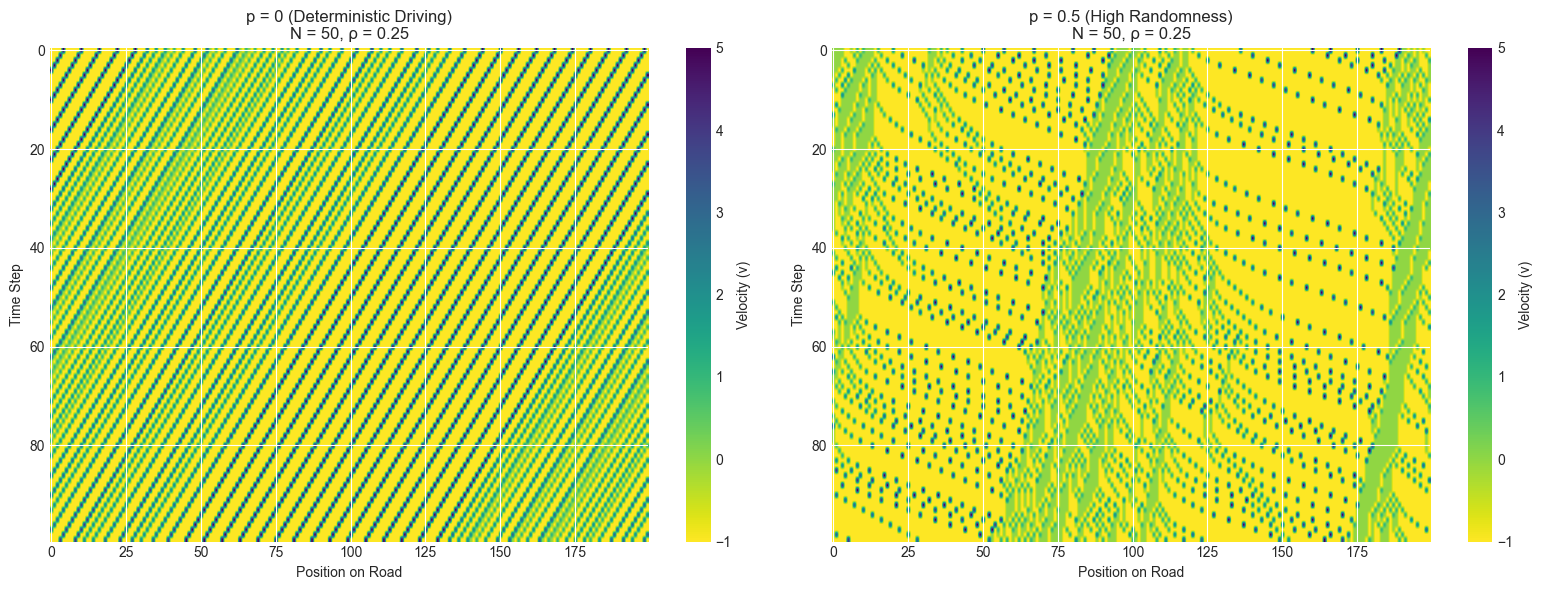


Part 2: Fundamental diagrams across all densities

Generating fundamental diagrams for both probability values...

Running experiments with p=0.0...
  Completed p=0.0
Running experiments with p=0.5...
  Completed p=0.5


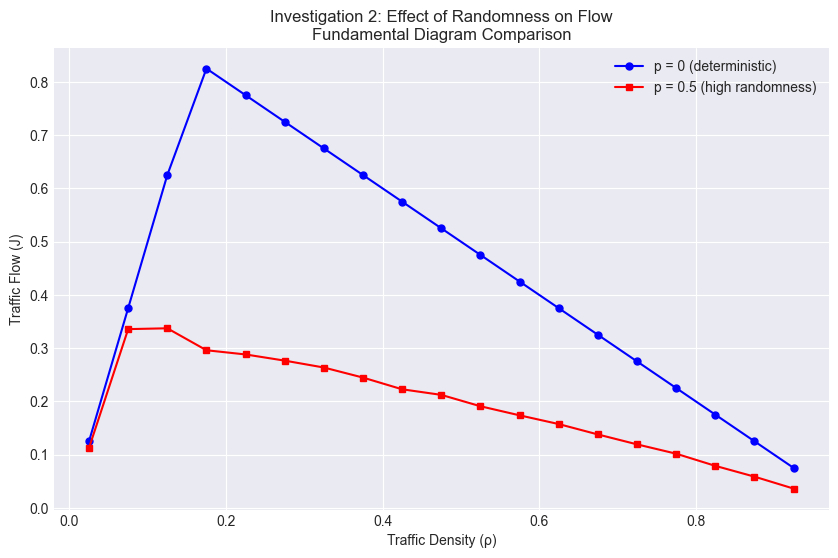


Conclusion:
- p=0: System remains perfectly stable with no jams
- p=0.5: Phantom jams emerge due to stochastic braking
- Randomness is necessary for spontaneous congestion
- Higher randomness significantly reduces maximum flow


In [70]:
# CELL 5: Investigation 2 - Effect of Human Reactions
# Question: Are traffic jams caused by density or driver unpredictability?

print("Investigation 2: Comparing p=0 (deterministic) vs p=0.5 (high randomness)")
print("Part 1: Space-time diagrams at moderate density\n")

# Fixed parameters for spacetime comparison
L = 200
n_cars = 50  # Moderate density (rho = 0.25)
v_max = 5
steps = 100
warmup = 200

# Run simulation with p=0 (deterministic)
print("Running with p=0 (deterministic driving)...")
model_p0 = TrafficModel(length=L, n_cars=n_cars, v_max=v_max, p=0.0)
for _ in range(warmup):
    model_p0.step()
history_p0 = model_p0.run(steps)

# Run simulation with p=0.5
print("Running with p=0.5 (high randomness)...")
model_p50 = TrafficModel(length=L, n_cars=n_cars, v_max=v_max, p=0.5)
for _ in range(warmup):
    model_p50.step()
history_p50 = model_p50.run(steps)

# Create side-by-side spacetime comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot p=0
im1 = ax1.imshow(history_p0, cmap='viridis_r', aspect='auto', vmin=-1, vmax=v_max)
ax1.set_xlabel("Position on Road")
ax1.set_ylabel("Time Step")
ax1.set_title("p = 0 (Deterministic Driving)\nN = 50, ρ = 0.25")
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label("Velocity (v)")

# Plot p=0.5
im2 = ax2.imshow(history_p50, cmap='viridis_r', aspect='auto', vmin=-1, vmax=v_max)
ax2.set_xlabel("Position on Road")
ax2.set_ylabel("Time Step")
ax2.set_title("p = 0.5 (High Randomness)\nN = 50, ρ = 0.25")
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label("Velocity (v)")

plt.tight_layout()
plt.savefig('images/investigation_2_spacetime_p0_vs_p05.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPart 2: Fundamental diagrams across all densities\n")
print("Generating fundamental diagrams for both probability values...\n")

# Store results for both p values
results = {}
measure_steps = 500

for p_value in [0.0, 0.5]:
    print(f"Running experiments with p={p_value}...")
    densities = []
    flows = []
    
    for n in range(5, 195, 10):
        model = TrafficModel(length=L, n_cars=n, v_max=v_max, p=p_value)
        
        # Warm-up
        for _ in range(warmup):
            model.step()
        
        # Measure flow
        total_distance = 0
        for _ in range(measure_steps):
            model.step()
            for pos in range(L):
                if model.road[pos] != -1:
                    total_distance += model.road[pos]
        
        density = n / L
        flow = total_distance / (L * measure_steps)
        
        densities.append(density)
        flows.append(flow)
    
    results[p_value] = {'densities': densities, 'flows': flows}
    print(f"  Completed p={p_value}")

# Plot fundamental diagram comparison
plt.figure(figsize=(10, 6))
plt.plot(results[0.0]['densities'], results[0.0]['flows'], '-o', 
         label='p = 0 (deterministic)', color='blue', markersize=5)
plt.plot(results[0.5]['densities'], results[0.5]['flows'], '-s', 
         label='p = 0.5 (high randomness)', color='red', markersize=5)
plt.xlabel("Traffic Density (ρ)")
plt.ylabel("Traffic Flow (J)")
plt.title("Investigation 2: Effect of Randomness on Flow\nFundamental Diagram Comparison")
plt.legend()
plt.grid(True)
plt.savefig('images/investigation_2_fundamental_diagram_p0_vs_p05.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConclusion:")
print("- p=0: System remains perfectly stable with no jams")
print("- p=0.5: Phantom jams emerge due to stochastic braking")
print("- Randomness is necessary for spontaneous congestion")
print("- Higher randomness significantly reduces maximum flow")

Investigation 3: Comparing v_max=5 vs v_max=2
Part 1: Space-time diagrams at moderate density

Running with v_max=5...
Running with v_max=2...


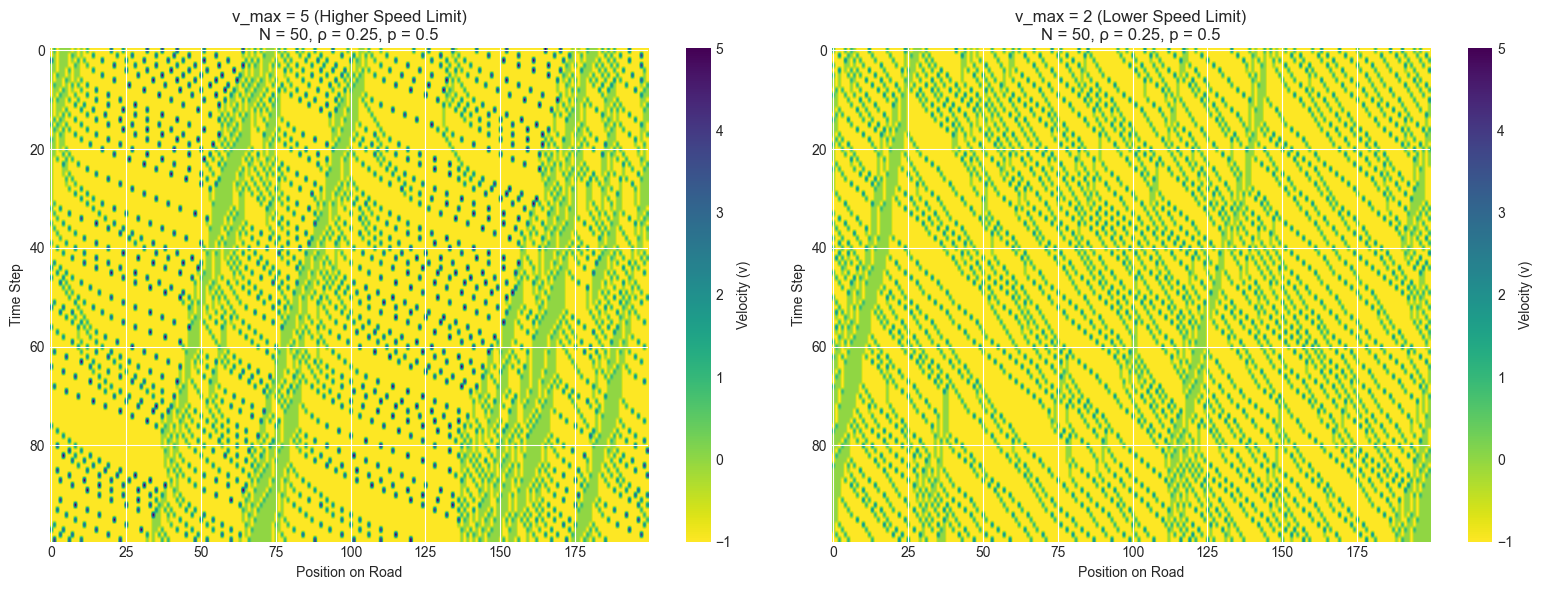


Part 2: Fundamental diagrams across all densities

Generating fundamental diagrams with p=0.5...

Running experiments with v_max=5...
  Completed v_max=5
Running experiments with v_max=2...
  Completed v_max=2


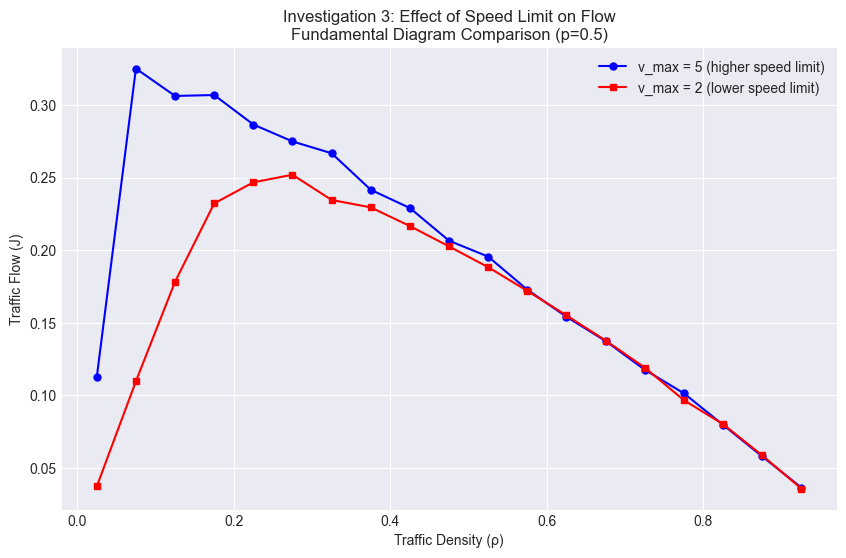


Conclusion:
- Spacetime diagrams show more stable flow with lower speed limit
- Lower speed limit (v_max=2) produces more stable flow
- Maximum flow is reduced but more consistent
- Lower speeds can help prevent jam formation


In [71]:
# CELL 6: Investigation 3 - Effect of Speed Limit
# Question: Does lowering the speed limit reduce traffic jams?

print("Investigation 3: Comparing v_max=5 vs v_max=2")
print("Part 1: Space-time diagrams at moderate density\n")

# Fixed parameters for spacetime comparison
L = 200
n_cars = 50  # Moderate density (rho = 0.25)
p = 0.5      # Use higher randomness to show effect clearly
steps = 100
warmup = 200

# Run simulation with v_max=5
print("Running with v_max=5...")
model_v5 = TrafficModel(length=L, n_cars=n_cars, v_max=5, p=p)
for _ in range(warmup):
    model_v5.step()
history_v5 = model_v5.run(steps)

# Run simulation with v_max=2
print("Running with v_max=2...")
model_v2 = TrafficModel(length=L, n_cars=n_cars, v_max=2, p=p)
for _ in range(warmup):
    model_v2.step()
history_v2 = model_v2.run(steps)

# Create side-by-side spacetime comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot v_max=5
im1 = ax1.imshow(history_v5, cmap='viridis_r', aspect='auto', vmin=-1, vmax=5)
ax1.set_xlabel("Position on Road")
ax1.set_ylabel("Time Step")
ax1.set_title("v_max = 5 (Higher Speed Limit)\nN = 50, ρ = 0.25, p = 0.5")
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label("Velocity (v)")

# Plot v_max=2
im2 = ax2.imshow(history_v2, cmap='viridis_r', aspect='auto', vmin=-1, vmax=5)
ax2.set_xlabel("Position on Road")
ax2.set_ylabel("Time Step")
ax2.set_title("v_max = 2 (Lower Speed Limit)\nN = 50, ρ = 0.25, p = 0.5")
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label("Velocity (v)")

plt.tight_layout()
plt.savefig('images/investigation_3_spacetime_vmax5_vs_vmax2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPart 2: Fundamental diagrams across all densities\n")
print("Generating fundamental diagrams with p=0.5...\n")

# Store results for both v_max values
results = {}
measure_steps = 500

for v_max in [5, 2]:
    print(f"Running experiments with v_max={v_max}...")
    densities = []
    flows = []
    
    for n in range(5, 195, 10):
        model = TrafficModel(length=L, n_cars=n, v_max=v_max, p=p)
        
        # Warm-up
        for _ in range(warmup):
            model.step()
        
        # Measure flow
        total_distance = 0
        for _ in range(measure_steps):
            model.step()
            for pos in range(L):
                if model.road[pos] != -1:
                    total_distance += model.road[pos]
        
        density = n / L
        flow = total_distance / (L * measure_steps)
        
        densities.append(density)
        flows.append(flow)
    
    results[v_max] = {'densities': densities, 'flows': flows}
    print(f"  Completed v_max={v_max}")

# Plot fundamental diagram comparison
plt.figure(figsize=(10, 6))
plt.plot(results[5]['densities'], results[5]['flows'], '-o', 
         label='v_max = 5 (higher speed limit)', color='blue', markersize=5)
plt.plot(results[2]['densities'], results[2]['flows'], '-s', 
         label='v_max = 2 (lower speed limit)', color='red', markersize=5)
plt.xlabel("Traffic Density (ρ)")
plt.ylabel("Traffic Flow (J)")
plt.title("Investigation 3: Effect of Speed Limit on Flow\nFundamental Diagram Comparison (p=0.5)")
plt.legend()
plt.grid(True)
plt.savefig('images/investigation_3_fundamental_diagram_vmax5_vs_vmax2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConclusion:")
print("- Spacetime diagrams show more stable flow with lower speed limit")
print("- Lower speed limit (v_max=2) produces more stable flow")
print("- Maximum flow is reduced but more consistent")
print("- Lower speeds can help prevent jam formation")